##Importação de bibliotecas e dados

Nesta etapa carregamos todas as bibliotecas necessárias (numpy, pandas, seaborn, matplotlib, scipy, sklearn) e lemos as diferentes abas do arquivo data_cube.xlsx.
O objetivo é ter acesso às tabelas de inscrição, medições de campo e adubação, que servirão de base para as análises.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import shapiro, levene, entropy

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(context="notebook")
random_state = 42

XLS_PATH = "data_cube.xlsx"

In [ ]:
xls = pd.ExcelFile(XLS_PATH)

f_insc = pd.read_excel(xls, sheet_name="fato_inscricao")
f_med = pd.read_excel(xls, sheet_name="fato_medicao")
d_adub = pd.read_excel(xls, sheet_name="dim_adubacao")
d_impl = pd.read_excel(xls, sheet_name="dim_implantacao_agricola")
d_gleb = pd.read_excel(xls, sheet_name="dim_gleba")
f_hist = pd.read_excel(xls, sheet_name="fato_historico_produtividade")

print("Abas carregadas.")
print("fato_inscricao:", f_insc.shape, "colunas:", list(f_insc.columns)[:10])
print("fato_medicao:", f_med.shape, "colunas:", list(f_med.columns)[:10])
print("dim_adubacao:", d_adub.shape, "colunas:", list(d_adub.columns)[:10])

Abas carregadas.
fato_inscricao: (51163, 7) colunas: ['inscricao_id', 'produtividade_final_sc_por_ha', 'custo_producao_reais_ha', 'valor_medio_venda', 'total_area_cultivada_soja_propriedade', 'area_agricultavel_propriedade', 'area_cultivada_soja_propriedade']
fato_medicao: (51163, 10) colunas: ['inscricao_id', 'populacao_plantas_calculada_ha', 'media_vagens_planta', 'graos_por_vagem_01', 'graos_por_vagem_02', 'graos_por_vagem_03', 'graos_por_vagem_04', 'media_stand_plantas', 'media_altura_plantas', 'media_insercao_primeira_vagem']
dim_adubacao: (97969, 10) colunas: ['id', 'data_semeadura', 'tipo_adubacao', 'fabricante', 'nome_comercial', 'unidade', 'modo_aplicacao', 'estadio_fenologico', 'origem', 'momento_aplicacao']


## Integração (Joins)

Aqui realizamos a integração entre as tabelas:

*   fato_inscricao (contém a produtividade final)
*   fato_medicao (características de campo)
*   dim_adubacao (informações de adubação)

A junção é feita principalmente pela chave inscricao_id.
Isso gera um dataset consolidado para nossas análises.

In [ ]:
df = (
    f_insc
    .merge(f_med, on="inscricao_id", how="left", suffixes=("", "_med"))
    .merge(d_adub, left_on="inscricao_id", right_on="id", how="left", suffixes=("", "_adub"))
)

print("\nDataset integrado (inscrição + medição + adubação):", df.shape)
print("Colunas (amostra):", list(df.columns)[:25])


Dataset integrado (inscrição + medição + adubação): (51169, 26)
Colunas (amostra): ['inscricao_id', 'produtividade_final_sc_por_ha', 'custo_producao_reais_ha', 'valor_medio_venda', 'total_area_cultivada_soja_propriedade', 'area_agricultavel_propriedade', 'area_cultivada_soja_propriedade', 'populacao_plantas_calculada_ha', 'media_vagens_planta', 'graos_por_vagem_01', 'graos_por_vagem_02', 'graos_por_vagem_03', 'graos_por_vagem_04', 'media_stand_plantas', 'media_altura_plantas', 'media_insercao_primeira_vagem', 'id', 'data_semeadura', 'tipo_adubacao', 'fabricante', 'nome_comercial', 'unidade', 'modo_aplicacao', 'estadio_fenologico', 'origem']


## Seleção de variáveis

Nesta etapa escolhemos:

* **Alvo (variável dependente):** `produtividade_final_sc_por_ha`
* **Variáveis numéricas:** população de plantas, vagens, altura, etc.
* **Variáveis categóricas:** tipo de adubação, fabricante, estádio fenológico, etc.

Esse filtro garante que trabalharemos apenas com colunas relevantes e disponíveis.

In [ ]:
TARGET = "produtividade_final_sc_por_ha"

num_features_candidates = [
    "populacao_plantas_calculada_ha",
    "media_vagens_planta",
    "graos_por_vagem_01",
    "graos_por_vagem_02",
    "graos_por_vagem_03",
    "graos_por_vagem_04",
    "media_stand_plantas",
    "media_altura_plantas",
    "media_insercao_primeira_vagem",
    "dose", "dosagem", "quantidade", "teor_n", "teor_p", "teor_k"
]

num_features = [c for c in num_features_candidates if c in df.columns]

cat_features_candidates = [
    "tipo_adubacao", "fabricante", "nome_comercial", "unidade",
    "estadio_fenologico", "momento_aplicacao", "modo_aplicacao",
    "formulacao", "origem"
]
cat_features = [c for c in cat_features_candidates if c in df.columns]

cols_needed = [TARGET, "inscricao_id"] + num_features + cat_features
dset = df.loc[:, [c for c in cols_needed if c in df.columns]].copy()

dset = dset[~dset[TARGET].isna()].copy()

print("\nVariáveis selecionadas:")
print("Alvo:", TARGET)
print("Numéricas:", num_features)
print("Categóricas:", cat_features)
print("Shape dset:", dset.shape)


Variáveis selecionadas:
Alvo: produtividade_final_sc_por_ha
Numéricas: ['populacao_plantas_calculada_ha', 'media_vagens_planta', 'graos_por_vagem_01', 'graos_por_vagem_02', 'graos_por_vagem_03', 'graos_por_vagem_04', 'media_stand_plantas', 'media_altura_plantas', 'media_insercao_primeira_vagem']
Categóricas: ['tipo_adubacao', 'fabricante', 'nome_comercial', 'unidade', 'estadio_fenologico', 'momento_aplicacao', 'modo_aplicacao', 'origem']
Shape dset: (51169, 19)


## Estatística descritiva

Realizamos estatísticas básicas do alvo e das variáveis independentes:

* Tendência central: média, mediana, moda
* Dispersão: variância, desvio-padrão, intervalo, IQR
* Correlações (Pearson/Spearman)

Também incluímos visualizações:

* Histograma da produtividade
* Boxplot para verificar outliers
* Heatmap de correlação entre variáveis



==================== 4) ESTATÍSTICA DESCRITIVA ====================
       produtividade_final_sc_por_ha  populacao_plantas_calculada_ha  \
count                    51,169.0000                      7,429.0000   
mean                         12.3971                  8,890,063.5740   
std                          30.6035                 67,031,213.8114   
min                           0.0000                          0.0000   
25%                           0.0000                        166.6660   
50%                           0.0000                    200,666.6670   
75%                           0.0000                    256,296.2960   
max                         149.0900              3,511,111,111.0000   

       media_vagens_planta  graos_por_vagem_01  graos_por_vagem_02  \
count           7,429.0000          7,429.0000          7,429.0000   
mean        3,423,746.9246         13,466.2520         13,485.8125   
std       112,219,111.8433      1,160,205.1715      1,160,204.9451   
mi

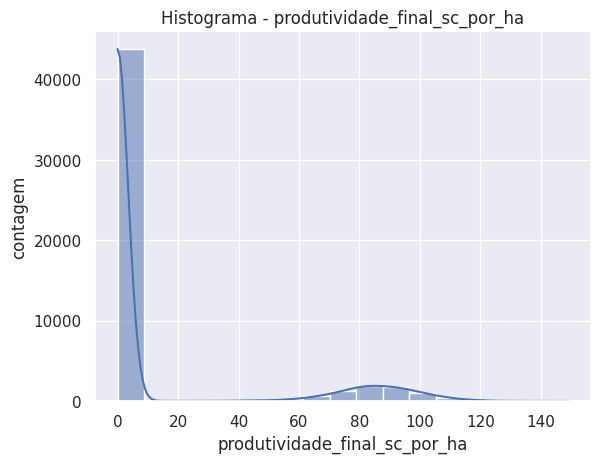

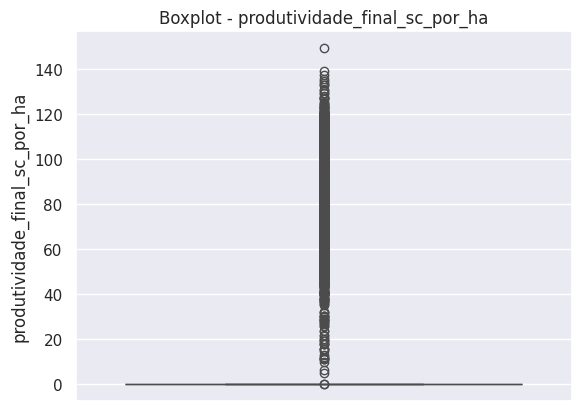

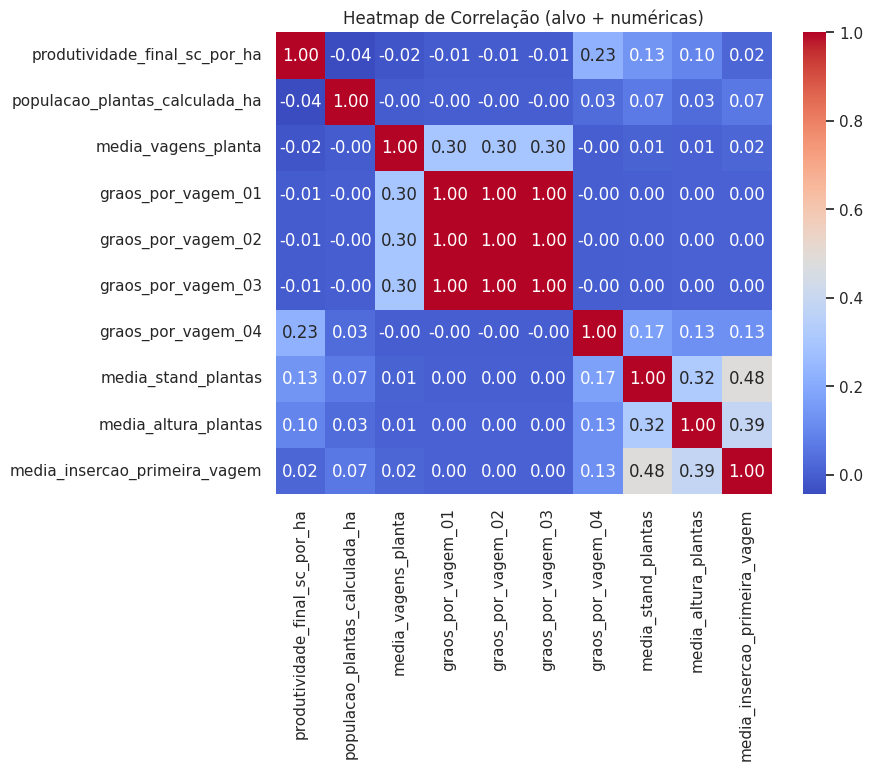

In [ ]:
print("\n ESTATÍSTICA DESCRITIVA")
desc = dset[[TARGET] + num_features].describe(include="all")
print(desc, "\n")

serie = dset[TARGET]
media = serie.mean()
mediana = serie.median()
moda_vals = serie.mode()
variancia = serie.var(ddof=1)
desvio = serie.std(ddof=1)
intervalo = serie.max() - serie.min()
Q1, Q3 = serie.quantile([0.25, 0.75])
iqr = Q3 - Q1

print(f"Média({TARGET}): {media:.3f}")
print(f"Mediana({TARGET}): {mediana:.3f}")
print(f"Moda({TARGET}): {', '.join(map(lambda x: f'{x:.2f}', moda_vals.values))}")
print(f"Variância({TARGET}): {variancia:.3f}")
print(f"Desvio-padrão({TARGET}): {desvio:.3f}")
print(f"Intervalo({TARGET}) = max - min: {intervalo:.3f}")
print(f"IQR({TARGET}) = Q3 - Q1: {iqr:.3f}\n")

if num_features:
    print("Correlação de Pearson (numéricas):")
    print(dset[[TARGET] + num_features].corr(numeric_only=True, method="pearson"), "\n")

    print("Correlação de Spearman (numéricas):")
    print(dset[[TARGET] + num_features].corr(numeric_only=True, method="spearman"), "\n")

plt.figure()
sns.histplot(dset[TARGET], kde=True)
plt.title(f"Histograma - {TARGET}")
plt.xlabel(TARGET)
plt.ylabel("contagem")
plt.show()

plt.figure()
sns.boxplot(y=dset[TARGET])
plt.title(f"Boxplot - {TARGET}")
plt.ylabel(TARGET)
plt.show()

if num_features:
    plt.figure(figsize=(8,6))
    sns.heatmap(dset[[TARGET] + num_features].corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Heatmap de Correlação (alvo + numéricas)")
    plt.show()

## Testes de hipóteses – ANOVA

Aplicamos o teste ANOVA para verificar se há diferença significativa na produtividade média entre os grupos definidos por **tipo de adubação**.

Passos incluídos:

* Definição das hipóteses H0 e H1
* Nível de significância α = 0,05
* Checagem de assunções: normalidade (Shapiro-Wilk) e homogeneidade de variâncias (Levene)
* Cálculo da estatística F e p-valor
* Cálculo do tamanho de efeito (eta²)
* Visualização com boxplot comparando os grupos

==================== 5) TESTES DE HIPÓTESES (ANOVA) ====================
Nível de significância adotado: α = 0.05

Shapiro-Wilk (normalidade) por grupo:
  COBERTURA: W = 0.500, p = 0.0000
  ORGANICA: W = 0.501, p = 0.0000
  PRE_SEMEADURA: W = 0.499, p = 0.0000
  SEMEADURA: W = 0.494, p = 0.0000

Levene (homogeneidade de variâncias): stat = 0.455, p = 0.7138

ANOVA: F = 0.455, p = 0.7138
Decisão: Não rejeitar H0 → não há evidências de diferença nas médias.

Tamanho de efeito (eta²): 0.0000 (pequeno ~0.01, médio ~0.06, grande ~0.14)



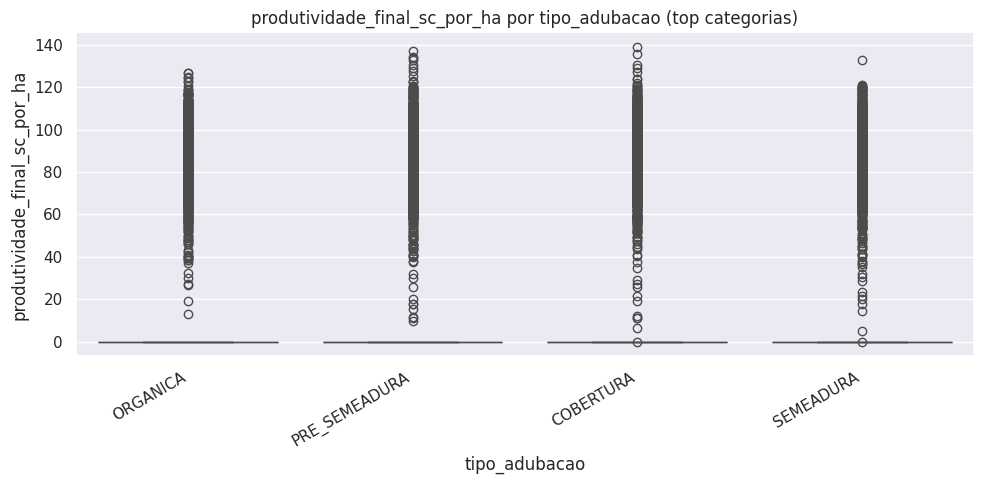

In [ ]:
print("TESTES DE HIPÓTESES (ANOVA)")
alpha = 0.05
print(f"Nível de significância adotado: α = {alpha}\n")

if "tipo_adubacao" in dset.columns:
    grupos = []
    labels = []
    for cat, sub in dset.groupby("tipo_adubacao"):
        vals = sub[TARGET].dropna().values
        if len(vals) >= 3:
            grupos.append(vals)
            labels.append(str(cat))

    if len(grupos) >= 2:
        print("Shapiro-Wilk (normalidade) por grupo:")
        for lab, g in zip(labels, grupos):
            if len(g) >= 3:
                W, pW = shapiro(g[:5000])
                print(f"  {lab[:40]}: W = {W:.3f}, p = {pW:.4f}")
        print()

        lev_stat, lev_p = levene(*grupos)
        print(f"Levene (homogeneidade de variâncias): stat = {lev_stat:.3f}, p = {lev_p:.4f}\n")

        F, p = stats.f_oneway(*grupos)
        print(f"ANOVA: F = {F:.3f}, p = {p:.4f}")
        if p < alpha:
            print("Decisão: Rejeitar H0 → pelo menos uma média difere.\n")
        else:
            print("Decisão: Não rejeitar H0 → não há evidências de diferença nas médias.\n")

        def eta_squared_from_groups(*groups):
            all_values = np.concatenate(groups)
            grand_mean = np.mean(all_values)
            ss_between = sum([len(g) * (np.mean(g) - grand_mean)**2 for g in groups])
            ss_total = np.sum((all_values - grand_mean)**2)
            return ss_between / ss_total

        eta2 = eta_squared_from_groups(*grupos)
        print(f"Tamanho de efeito (eta²): {eta2:.4f} "
              f"{'(pequeno ~0.01, médio ~0.06, grande ~0.14)'}\n")

        top_cats = dset["tipo_adubacao"].value_counts().index[:8]
        subset = dset[dset["tipo_adubacao"].isin(top_cats)]
        plt.figure(figsize=(10,5))
        sns.boxplot(data=subset, x="tipo_adubacao", y=TARGET)
        plt.title(f"{TARGET} por tipo_adubacao (top categorias)")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Não há grupos suficientes de 'tipo_adubacao' com amostra >= 3 para ANOVA.\n")
else:
    print("Coluna 'tipo_adubacao' não está disponível para ANOVA.\n")

## Teoria da informação

Nesta parte calculamos métricas da teoria da informação:

* Entropia (exemplo didático em precipitação categorizada)
* Informação mútua (mutual information) entre variáveis independentes e a produtividade

Com isso, montamos um **ranking de relevância** de variáveis para o modelo, indicando quais mais contribuem para explicar a produtividade

In [ ]:
print(" TEORIA DA INFORMAÇÃO ")

X_mi = dset[num_features].copy() if num_features else pd.DataFrame(index=dset.index)
y = dset[TARGET].copy()

cat_for_mi = [c for c in ["tipo_adubacao", "fabricante", "nome_comercial"] if c in dset.columns]
if cat_for_mi:
    X_cat = pd.get_dummies(dset[cat_for_mi], drop_first=True)
    X_mi = pd.concat([X_mi, X_cat], axis=1)

if X_mi.shape[1] >= 1:
    X_mi = X_mi.dropna(axis=1, how="all")
    X_mi = X_mi.fillna(X_mi.mean(numeric_only=True))
    mi_vals = mutual_info_regression(X_mi, y, random_state=random_state)
    mi_ranking = pd.Series(mi_vals, index=X_mi.columns).sort_values(ascending=False)
    print("Ranking por Informação Mútua (variável → produtividade):")
    print(mi_ranking.head(25), "\n")
else:
    print("Sem variáveis numéricas/categóricas codificadas suficientes para MI.\n")

==================== 6) TEORIA DA INFORMAÇÃO ====================
Ranking por Informação Mútua (variável → produtividade):
graos_por_vagem_02                           0.4216
graos_por_vagem_04                           0.4210
populacao_plantas_calculada_ha               0.4179
graos_por_vagem_01                           0.4179
media_insercao_primeira_vagem                0.4157
graos_por_vagem_03                           0.4134
media_vagens_planta                          0.4100
media_altura_plantas                         0.4032
media_stand_plantas                          0.4002
nome_comercial_3-21-21                       0.0118
nome_comercial_MISTURA DE GRANULOS           0.0116
nome_comercial_00.18.18 ESTRA TOTAL PLUS     0.0113
fabricante_OUROFERTIL                        0.0110
nome_comercial_09 40 00 MES                  0.0105
nome_comercial_FOS                           0.0104
nome_comercial_TOP-PHÓS NP PLUS              0.0099
nome_comercial_TOP PHOS 328                  